# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [ ]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

# For the regression model and evaluation
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneOut, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from typing import Tuple, Optional
from dataclasses import dataclass

from courier import Job, Courier

plt.rc('font', size=15)

## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [ ]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())
    network = str(parts[3])[3:] if len(parts) > 3 else 'lenet'

    return cpu, batch, njobs, network

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication



# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'replication': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'network': [],
    'time': [],
    'accuracies':[],
    'final_accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)


replications = 3

for r in range(1, 1+replications):
    # This is the path we should change to either analyze the 2k or the full factorial
    path_root_master = f'./experiments/2k/{r}/master/'
    
    # get the log files
    logs = glob.glob(os.path.join(path_root_master, '*.log'))
    
    
    print(f'Extracting the data from {len(logs)} files')
    for log in logs:
        acc = []
        with open(log, 'r') as f:
            for line in f:
                if 'Top1Accuracy is Accuracy' in line:
                    try:
                        _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                        acc.append(float(_accuracy.strip()))
                    except Exception as e:
                        print('Error while reading accuracy',e)
                    if len(acc) == 10:
                        # Then save the time here
                        time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                        break
        # Add the results to the dictionary
        variables = log.split('-')[1:]
        if len(variables) < 4:
            variables[-1] = variables[-1].split('.')[0]
            variables.append('netlenet5')
        name = '-'.join(variables).replace('.log', '')
        cpu, batch, njobs , network= split_name(name)
        # set all the columns
        results['cpu'].append(cpu)
        results['batch'].append(batch)
        results['njobs'].append(njobs)
        results['network'].append(network)
        results['accuracies'].append(acc)
        results['time'].append(time)
        results['final_accuracy'].append(acc[-1])
        results['exp_name'].append(name)
        results['replication'].append(r)


results_df = pd.DataFrame(results)
# results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df


# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [ ]:
def coalesce_metrics(loads, replication, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""
    # Dict to build the dataframe
    avg_loads = {
        'exp_name': [],
        'replication': [],
        'cpu_load': [],
        'iowait': [],
        'cpu_mean': [],
        'iowait_mean':[]
    }

    for exp, slaves in loads.items():
        # print(f'\n{exp}')
        count = 0
        list_length = len(list(slaves['slave1'].values())[0])
        c = np.zeros(list_length)
        io = np.zeros(list_length)
        for slave, metrics in slaves.items():

            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <threshold:
                # print(f'Discarding {slave} with cpu mean =',cpu_mean)
                pass
            else:
                c += metrics['cpu']
                io += metrics['iowait']
                count += 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        # print('dividing by ',count)
        avg_loads['exp_name'].append(exp)
        avg_loads['replication'].append(replication)
        avg_loads['cpu_load'].append(c / count)
        avg_loads['iowait'].append(io/count)
        avg_loads['cpu_mean'].append(np.mean(c/count))
        avg_loads['iowait_mean'].append(np.mean(io/count))

    return avg_loads

In [ ]:
dfs = []

for replication in [1, 2, 3]:
    print('Starting with replication ',replication)
    root_folder_slaves = f'./experiments/2k/{replication}'

    dirs = os.listdir(root_folder_slaves)
    slave_dirs = [f for f in dirs if 'slave' in f]
    print(slave_dirs)


    loads = defaultdict(dict)
    # The shape of the results is
    # name of the file:
    #     - slave 1:
    #         - cpu: list
    #         - iowait: list
    #     - slave 2:
    #         ...

    # Do the same in all the folders
    for folder in slave_dirs:
        print('Processing files for the', folder)
        # get just the pickle files
        files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

        # Extract the dictionary from each file
        for f in files:

            # Get the name of the experiment to index the other dict
            variables = f.split('-')[1:]
            if len(variables) < 4:
                variables.append('netlenet5')
            exp_name = '-'.join(variables).replace('.pkl', '')
#             print(exp_name)
#             print(f)

            with open(f, 'rb') as pickle_file:
                metrics = pickle.load(pickle_file)

            # Now we need to check to just get the metrics concerning the experiment
            # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
            # to not cut too tightly
            exp_length = results_df.loc[(results_df.exp_name == exp_name) & (results_df.replication == replication), 'time'].array[0]
            if exp_length > 300:
                loads[exp_name][folder] = metrics

            else:
                max_list_length = math.ceil(exp_length/2) + 5
                # print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
                if max_list_length < len(metrics['cpu']):
                    loads[exp_name][folder] = dict()
                    loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                    loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
                else:
                    # Add the whole of it
                    loads[exp_name][folder] = metrics

    # Get the average usage of the experiments
    # The resulting dict will just map each
    # pf the experiments to its avg cpu load and
    # iowait across all slaves

    avg_loads = coalesce_metrics(loads, replication)
    loads_df = pd.DataFrame(avg_loads)
    print('build dataframe')
    dfs.append(loads_df)

# Concat all of the dataframes into one
load_df = None

for df in dfs:
    load_df = df if results_df is None else pd.concat([load_df, df], ignore_index=True)

### Merge the dataframes together so we get a common dataframe for all results


In [ ]:
# Merge the two dataframes so we get all the data grouped by experiment number
final_df = results_df.merge(load_df, on=['exp_name', 'replication'])

***
# If everything is already done load the data from the file

In [ ]:
final_df = pd.read_pickle('./experiments/fullfact/complete_data.pkl')

## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

### See the relationship with time

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='time', hue='batch', data=final_df, ax=ax1)
sns.barplot(x='cpu', y='time', hue='batch', data=final_df, ax=ax2)

final_df['processes'] = final_df['cpu'] * final_df['njobs']
sns.barplot(x='processes', y='time', hue='network',data=final_df, ax=ax3)
sns.barplot(x='batch', y='time', hue='network', data=final_df, ax=ax4);


### See the relationships with the accuracy


In [ ]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

# sns.violinplot(x='njobs', y='final_accuracy', data=final_df, ax=ax1)
# sns.violinplot(x='cpu', y='final_accuracy', data=final_df, ax=ax2)

# final_df['processes'] = final_df['cpu'] * final_df['njobs']
# sns.violinplot(x='processes', y='final_accuracy', data=final_df, ax=ax3)
# sns.barplot(x='batch', y='final_accuracy', hue='network', data=final_df, ax=ax4)


plt.figure(figsize=(15,6))
# sns.barplot(x='batch', y='final_accuracy', hue='network', data=final_df)
# plt.ylim([0.87,1])
sns.violinplot(x='processes', y='final_accuracy', data=final_df)
plt.savefig('./figures/accuracy_only_batch.pdf')


### See the relationship with the cpu load and iowait

In [ ]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

# sns.violinplot(x='njobs', y='cpu_mean', data=final_df, ax=ax1)
# sns.violinplot(x='cpu', y='cpu_mean', data=final_df, ax=ax2)

# final_df['processes'] = final_df['cpu'] * final_df['njobs']
# sns.barplot(x='processes', y='cpu_mean', hue='network', data=final_df, ax=ax3)
# sns.barplot(x='batch', y='cpu_mean', hue = 'cpu', data=final_df, ax=ax4);



plt.figure(figsize=(15,6))
sns.violinplot(x='njobs', y='cpu_mean', data=final_df)
plt.savefig('./figures/njobs-vs-cpu_mean.pdf')


In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='iowait_mean', data=final_df, ax=ax1)
sns.barplot(x='cpu', y='iowait_mean', data=final_df, ax=ax2)

final_df['processes'] = final_df['cpu'] * final_df['njobs']
sns.lineplot(x='processes', y='iowait_mean', data=final_df, ax=ax3)
sns.barplot(x='batch', y='iowait_mean', data=final_df, ax=ax4);


final_df.groupby('njobs').mean()

## Run some statistical tests to see if the batch influences any of the outputs

In [ ]:
# run for batch with the IO, CPU...

from scipy.stats import mannwhitneyu
import itertools

def njobs_significance_test(column: str):

    print('Starting jobs significance test for column', column)

    # Divide in batches
    n0 = final_df[final_df.njobs == 1][column]
    n1 = final_df[final_df.njobs == 3][column]
    n2 = final_df[final_df.njobs == 5][column]

    jobs = {1: n0,
               3:n1,
               5:n2
    }

    # Calculate p-values
    combinations = itertools.combinations(list(jobs.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(jobs[i], jobs[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

def cpu_significance_test(column: str):

    print('Starting cpu significance test for column', column)

    # Divide in batches
    c0 = final_df[final_df.cpu == 1][column]
    c1 = final_df[final_df.cpu == 2][column]
    c2 = final_df[final_df.cpu == 4][column]
    c3 = final_df[final_df.cpu == 8][column]

    cpus = {1: c0,
               2:c1,
               4:c2,
               8:c3
    }

    # Calculate p-values
    combinations = itertools.combinations(list(cpus.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(cpus[i], cpus[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()


def batch_significance_test(column: str):

    print('Starting batch significance test for column', column)

    # Divide in batches
    b0 = final_df[final_df.batch == 64][column]
    b1 = final_df[final_df.batch == 128][column]
    b2 = final_df[final_df.batch == 256][column]
    b3 = final_df[final_df.batch == 512][column]

    batches = {64: b0,
               128:b1,
               256:b2,
               512:b3
    }

    # Calculate p-values
    combinations = itertools.combinations([64,128,256,512], 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(batches[i], batches[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

for col in ['time', 'final_accuracy', 'cpu_mean', 'iowait_mean']:
    print(f'--------- {col.upper()} ------------')
    batch_significance_test(col)
    njobs_significance_test(col)
    cpu_significance_test(col)

## Try to calculate the service rate of the disk based on the number of jobs and the batch

In [ ]:
Tcpu = 0.045
mu_cpu = 1/Tcpu
num_examples = 60000
num_epochs = 10

mus = {
    'batch':[],
    'cpu':[],
    'processes':[],
    'njobs':[],
    'mu':[],
    'time':[]
}

for i, row in final_df.iterrows():
    # Calculate the new numbers
    l_disk = max(1, (row.njobs * row.cpu)/3) * mu_cpu
    T = row.time
    Nt = (num_examples/row.batch) * num_epochs
    mu_disk = (1/((T/Nt) - Tcpu)) + l_disk
    
    mus['batch'].append(row.batch)
    mus['cpu'].append(row.cpu)
    mus['processes'].append(row.njobs * row.cpu)
    mus['njobs'].append(row.njobs)
    mus['mu'].append(mu_disk)
    mus['time'].append(row.time)

    
df_mu = pd.DataFrame(mus)

df_mu.groupby(['batch', 'njobs']).mean()

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 10))

sns.lineplot(x='batch', y='mu', data=df_mu, ax=ax1)
sns.lineplot(x='processes', y='mu', data=df_mu, ax=ax2)
sns.lineplot(x='cpu', y='mu', data=df_mu, ax=ax3)


In [ ]:
Tcpu = 0.045
mu_cpu = 1/Tcpu
num_examples = 60000
num_epochs = 10


# See how well it does just on the training dataframe
labels_time = final_df['time']

# Divide into train and test set
train_df = final_df
x_train, x_test, y_train_mu, y_test_mu = train_test_split(df_mu, df_mu['mu'], test_size=0.2, random_state = 42)

res = {
    'expected':[],
    'actual':[]
}

lr = LinearRegression()
lr.fit(x_train[['batch', 'processes']], y_train_mu)


# Time for all the rows in the test set 
for _, row in x_test.iterrows():
    # Measured time
    T_true = row.time
    
    # Apply the formula
    l_disk = max(1, row.processes/3) * mu_cpu
    mu_disk = lr.predict([[row.batch,row.processes]])[0]
    Nt = (num_examples/row.batch) * num_epochs
    Tdisk = 1/(mu_disk - l_disk)
    
    T = Nt * (Tcpu + Tdisk)
    res['expected'].append(T)
    res['actual'].append(T_true)
    
res_df = pd.DataFrame(res)

# display(res_df)
    
# Get the MSE and the R2 score of the model
# 2) Get the predictions for the accuracy
mse_t = mean_squared_error(res_df['actual'], res_df['expected'])
r2_t = r2_score(res_df['actual'], res_df['expected'])

print(f'TIME: MSE = {mse_t}, R2: {r2_t}')


In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(x_test['processes'], res_df['actual'], label="True values")
plt.scatter(x_test['processes'], res_df['expected'], label="Predicted values")

plt.xlabel('Processes')
plt.ylabel('Time(s)')

plt.legend()

## Run the ANOVA tests on this data 

We want to see how factors like number of CPUs, Jobs, and Batch influence all the others
- Accuracy
- E(T)
- CPU Usage
- IO Wait

In [ ]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the cpu, batch and njobs columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['cpu', 'batch', 'njobs', 'network']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*C(network)', df).fit()
        
    else:
        if y not in ['final_accuracy', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['cpu', 'batch', 'njobs', 'cpu_mean', 'iowait_mean']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [ ]:
# Simply change the output value for the y to the variable that you want to study
# - iowait_mean
# - final_accuracy
# - time
# - cpu_mean
res, model = ANOVA(final_df, y='time', verbose=True)
res

### See how well the model can fit the test set

In [ ]:
# After we get the model we can try to fit in on the x_train
labels_time = final_df['time']
labels_acc = final_df['final_accuracy']

train_df = final_df
train_df['network'] = train_df['network'].apply(lambda net: 1 if net == 'lenet5' else -1)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.2, random_state = 42)
x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.2, random_state = 42)

_, model_time = ANOVA(x_train, y='time')
_, model_acc = ANOVA(x_train, y='final_accuracy')

In [ ]:
# Get the MSE and the R2 score
y_pred_time_anova = model_time.predict(x_test)
y_pred_acc_anova = model_acc.predict(x_test)

# 1) Get the predictions for the time
mse_t = mean_squared_error(y_pred_time_anova, y_test_time)
r2_t = r2_score(y_pred_time_anova, y_test_time)

print(f'TIME: MSE = {mse_t}, R2: {r2_t}')


# 2) Get the predictions for the accuracy
mse_acc = mean_squared_error(y_pred_acc_anova, y_test_acc)
r2_acc = r2_score(y_pred_acc_anova, y_test_acc)

print(f'ACC: MSE = {mse_acc}, R2: {r2_acc}')

In [ ]:
# Pritn the predictions and the true values

f, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))

ax1.scatter(x_test.processes, y_test_time, 'ro', label='True labels')
ax1.scatter(x_test.processes, y_pred_time_anova, label='Predicted values')

ax1.set_xlabel('Number of processes')
ax1.set_ylabel('Time (s)')

ax2.scatter(x_test.processes, y_test_acc, label='True labels')
ax2.scatter(x_test.processes, y_pred_acc_anova, label='Predicted values')

ax2.set_xlabel('Number of processes')
ax2.set_ylabel('Accuracy')

ax1.legend()
ax2.legend()

## Fit the Data with the Random Forest Classifier

In [ ]:
scaler = StandardScaler()

# Create the interaction column
final_df['processes'] = final_df['cpu'] * final_df['njobs']

# Get the data split into train and test
train_df = final_df[['processes', 'cpu', 'njobs', 'batch', 'network']]
train_df['network'] = train_df['network'].apply(lambda net: 1 if net == 'lenet5' else -1)

labels_time = final_df['time']
labels_acc = final_df['final_accuracy']

train_df = scaler.fit_transform(train_df)
train_df

# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams
x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.2, random_state = 42)

In [ ]:
reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500, 1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

### Fit the regressors on the accuracy and time

In [ ]:
cv_acc.best_params_

In [ ]:
cv_time.best_params_

In [ ]:


# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

***
### Fit the data with the Gradient Boosting Classifier

Fit the data with the best regressor and the same features that they used in the reference paper
We will use the features that the authors use and that we add the batch and network

In [ ]:
scaler = StandardScaler()


# Define the dataframe with the columns cores, 
comp_df = final_df[['cpu', 'batch', 'network']]
comp_df['network'] = comp_df['network'].apply(lambda net: 1 if net == 'lenet5' else -1)
labels_time = final_df['time']
labels_acc = final_df['final_accuracy']

# Standardize the data
train_df = scaler.fit_transform(comp_df)
train_df

# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams
x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.2, random_state = 42)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

reg_acc = GradientBoostingRegressor(random_state=42)
reg_time = GradientBoostingRegressor(random_state=42)

params = {
    'n_estimators': [50, 100, 150, 200, 500, 1000, 2000],
    'loss': ['ls', 'lad', 'huber'],
    'max_depth': range(3,10),
}


# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

In [ ]:
print(cv_time.best_params_)
print(cv_acc.best_params_)

In [ ]:
# fit the gradient boosters with the best parameters
gb_t = GradientBoostingRegressor(n_estimators=50,
                                max_depth=3,
                                loss='lad',
                                random_state=42).fit(x_train, y_train_time)

gb_acc = GradientBoostingRegressor(n_estimators=50,
                                  max_depth=3,
                                  loss='ls',
                                  random_state=42).fit(x_train, y_train_acc)

# Get the predictions from the models

# 1) Get the performance from time
y_pred_time = gb_t.predict(x_test)
mse_t = mean_squared_error(y_test_time, y_pred_time)
r2_t = r2_score(y_test_time, y_pred_time)
print(f'TIME: MSE = {mse_t}, R2: {r2_t}')

# 2) Get the performance for the accuracy
y_pred_acc = gb_acc.predict(x_test)
mse_acc = mean_squared_error(y_test_acc, y_pred_acc)
r2_acc = r2_score(y_test_acc, y_pred_acc)
print(f'ACC: MSE = {mse_acc}, R2: {r2_acc}')

In [ ]:
gb_t.feature_importances_

In [ ]:
models = {'accuracy':gb_acc, 'time':gb_t}
c = Courier(models, scaler)
with open('courier_boost.pkl', 'wb') as f:
    pickle.dump(c, f)

### Fit the resulting best hyperparams from the GridSearch 

In [ ]:
# Fit the regressor for time with the best params
r_t = RandomForestRegressor(n_estimators=2000, 
                            criterion='mae', 
                            max_features='auto', 
                            max_depth=6, 
                            random_state=42, n_jobs=6).fit(x_train, y_train_time)

# Fit the regressor for Accuracy with the best params
r_acc= RandomForestRegressor(n_estimators=150, 
                             criterion='mae', 
                             max_features='auto', 
                             max_depth=9, 
                             random_state=42, n_jobs=6).fit(x_train, y_train_acc)

In [ ]:
# Get the predictions from the models

# 1) Get the performance from time
y_pred_time = r_t.predict(x_test)

mse_t = mean_squared_error(y_test_time, y_pred_time)
r2_t = r2_score(y_test_time, y_pred_time)
print(f'TIME: MSE = {mse_t}, R2: {r2_t}')

# 2) Get the performance for the accuracy
y_pred_acc = r_acc.predict(x_test)

mse_acc = mean_squared_error(y_test_acc, y_pred_acc)
r2_acc = r2_score(y_test_acc, y_pred_acc)
print(f'ACC: MSE = {mse_acc}, R2: {r2_acc}')

In [ ]:
# Pritn the predictions and the true values
f, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

ax1.scatter(x_test[:,0], y_test_time, label='True labels')
ax1.errorbar(x_test[:,0], y_pred_time, yerr=y_test_time-y_pred_time, fmt='o', marker='^', c='r', label='Predicted values')

ax1.set_xlabel('Normalized number of processes', fontsize=17)
ax1.set_ylabel('Time (s)', fontsize=17)

ax2.scatter(x_test[:,0], y_test_acc,label='True labels')
ax2.errorbar(x_test[:,0], y_pred_acc, yerr=y_test_acc-y_pred_acc, fmt='o', marker='^', c='r', label='Predicted values')

ax2.set_xlabel('Normalized number of processes', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=17)

ax1.legend(fontsize=17)
ax2.legend(fontsize=17)

plt.savefig('./figures/random_forest_plot.pdf')

In [ ]:
for f, imp in zip(['processes', 'cpu', 'njobs', 'batch', 'network'],r_t.feature_importances_ ):
    print(f, imp)
    
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,7))
ax1.bar(['processes', 'cpu', 'njobs', 'batch', 'network'], r_t.feature_importances_)
ax2.bar(['processes', 'cpu', 'njobs', 'batch', 'network'], r_acc.feature_importances_)
ax1.tick_params(axis='x',rotation=40)
ax1.tick_params(axis='both',labelsize=13)

ax2.tick_params(axis='x',rotation=40)
ax2.tick_params(axis='both',labelsize=13)


ax1.set_ylabel('Importance', fontsize=17)
ax1.set_xlabel('Features Resp. Time', fontsize=17)
ax2.set_xlabel('Features Accuracy', fontsize=17)

plt.tight_layout()

plt.savefig('./figures/importance.pdf')

# Courier experiments

In [ ]:
# Create the Courier
from courier import Courier
with open('./courier.pkl', 'rb') as f:
    courier = pickle.load(f)
    
courier   

with open('./courier_boost.pkl', 'rb') as f:
    courier_boost = pickle.load(f)

In [70]:
results_root_path = './experiments/courier'
exp_path = './experiment_designs/courier_exp.csv'

# Load the experiments
exps = pd.read_csv(exp_path)

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[1].replace('cpu', '').strip())
    batch = int(parts[2].replace('batch', '').strip())
    njobs = int(parts[3].replace('njobs', '').strip())
    network = str(parts[4])[4:] if len(parts) > 4 else 'lenet'
    
    return cpu, batch, njobs, network
    


def read_logs(folder:str):
    results = {
        'exp_name': [],
        'replication': [],
        'cpu': [],
        'batch': [],
        'njobs': [],
        'network': [],
        'time': [],
        'accuracies':[],
        'final_accuracy': []
    }


    # 1) Load the results from the courier part of the experiments
    # We need to do as with the normal experiments for the ANOVA and extract the accuracies and time
    for replication in [1,2,3]:
        logs = glob.glob(os.path.join(results_root_path, folder, str(replication), '*.log'))
        

        print(f'Extracting the data from {len(logs)} files')
        for log in logs:
            acc = []
            with open(log, 'r') as f:
                time = 0
                for line in f:
                    if 'Top1Accuracy is Accuracy' in line:
                        try:
                            _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                            acc.append(float(_accuracy.strip()))
                        except Exception as e:
                            print('Error while reading accuracy',e,log)
                        if len(acc) == 10:
                            # Then save the time here
                            time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                            break
            # Add the results to the dictionary
            variables = log.split('-')[:-1]
            variables[0] = variables[0][-1]
            if len(variables) < 4:
                variables[-1] = variables[-1].split('.')[0]
                variables.append('netlenet5')
            name = '-'.join(variables).replace('.log', '')
            cpu, batch, njobs , network= split_name(name)
            if time == 0:
                print(log, "time not found")
            # set all the columns
            results['cpu'].append(cpu)
            results['batch'].append(batch)
            results['njobs'].append(njobs)
            results['network'].append(network)
            results['accuracies'].append(acc)
            results['time'].append(time)
            results['final_accuracy'].append(acc[-1])
            results['exp_name'].append(name)
            results['replication'].append(replication)
            
    return pd.DataFrame(results)

def get_courier_predictions(df: pd.DataFrame, c: Courier, test= False) -> pd.DataFrame:
    """Gets the predictions for what courier predicts based on the jobs, cpu for a dataframe"""
    preds = {
        'exp_name':[],
        'best_batch':[],
        'predicted_time':[],
        'predicted_accuracy':[],
        'cpu':[],
        'njobs':[],
        'latency':[]
    }
    
    df['network'] = df['network'].apply(lambda n: 1 if n == 'lenet5' else -1)
    
    for i, row in df[df.index<5].iterrows():
        # Get the prediction from courier
        latency = exps.iloc[i].latency
        j = Job(cpu=row.cpu, njobs=row.njobs, network=row.network)
        print(f'Row {i}, job = {j}')
        if test:
            best_batch, (acc, t) = c.optimize(j, latency, test=True)
        else:
            best_batch, (acc, t) = c.optimize(j, latency, test=False)
        preds['exp_name'].append(row.exp_name)
        preds['best_batch'].append(best_batch)
        preds['predicted_time'].append(t)
        preds['predicted_accuracy'].append(acc)
        preds['cpu'].append(row.cpu)
        preds['njobs'].append(row.njobs)
        preds['latency'].append(latency)
    
    return pd.DataFrame(preds)


In [ ]:
preds_boost

### Get the results from the courier model and the random model 

In [83]:
results_courier = read_logs('courier')
# results_other = read_logs('other')
preds = get_courier_predictions(results_courier, courier)
preds_boost = get_courier_predictions(results_courier, courier_boost, test=True)

# fix error in reading experiment 4 in replication 3
# results_courier.at[7, 'time'] =  99.247516804

results_courier.at[13, 'time'] = 283.80912464

# # fix errors reading other files
# results_other.at[2, 'time'] = 425.409302788
# results_other.at[6, 'time'] = 315.031166931
# results_other.at[10, 'time'] = 526.367967449
# results_other.at[11, 'time'] = 503.676117105
# results_other.at[12, 'time'] = 454.128488997
# results_other.at[22, 'time'] = 443.461306044
# results_other.at[27, 'time'] = 89.615384517


results_courier

# results_courier.to_pickle('./experiments/courier/res.pkl')

Extracting the data from 5 files
Extracting the data from 5 files
Extracting the data from 5 files
./experiments/courier\courier\3\3-cpu8-batch512-njobs3-netlenet5-courier.log time not found
Row 0, job = Job(cpu=2, njobs=1, network=-1)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

Row 1, job = Job(cpu=4, njobs=1, network=-1)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

Row 2, job = Job(cpu=1, njobs=5, network=-1)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

Row 3, job = Job(cpu=8, njobs=3, network=-1)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

Row 4, job = Job(cpu=4, njobs=2, network=-1)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

Row 0, job = Job(cpu=2, njobs=1, network=-1)
Row 1, job = Job(cpu=4, njobs=1, network=-1)
Row 2, job = Job(cpu=1, njobs=5, network=-1)
Row 3, job = Job(cpu=8, njobs=3, network=-1)
Row 4, job = Job(cpu=4, njobs=2, network=-1)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

,exp_name,replication,cpu,batch,njobs,network,time,accuracies,final_accuracy
0,0-cpu2-batch128-njobs1-netlenet5,1,2,128,1,-1,289.996720,"[0.8112, 0.8747, 0.9005, 0.913, 0.9229, 0.9283...",0.9432
1,1-cpu4-batch128-njobs1-netsimplenet,1,4,128,1,-1,240.389723,"[0.89, 0.9062, 0.9151, 0.9205, 0.925, 0.9284, ...",0.9373
2,2-cpu1-batch128-njobs5-netsimplenet,1,1,128,5,-1,250.781757,"[0.8922, 0.9092, 0.9183, 0.9212, 0.9252, 0.928...",0.9381
3,3-cpu8-batch512-njobs3-netlenet5,1,8,512,3,-1,117.617714,"[0.5545, 0.7195, 0.7654, 0.8057, 0.8319, 0.848...",0.8883
4,4-cpu4-batch128-njobs2-netlenet5,1,4,128,2,-1,282.385703,"[0.8151, 0.8772, 0.9028, 0.915, 0.9225, 0.9278...",0.9431
5,0-cpu2-batch128-njobs1-netlenet5,2,2,128,1,-1,318.513774,"[0.8143, 0.8775, 0.9023, 0.9152, 0.9246, 0.930...",0.9453
6,1-cpu4-batch128-njobs1-netsimplenet,2,4,128,1,-1,266.833128,"[0.8899, 0.9074, 0.9163, 0.9223, 0.9268, 0.930...",0.9387
7,2-cpu1-batch128-njobs5-netsimplenet,2,1,128,5,-1,265.072316,"[0.8915, 0.9092, 0.9172, 0.9216, 0.9276, 0.929...",0.9398
8,3-cpu8-batch512-njobs3-netlenet5,2,8,512,3,-1,125.159489,"[0.4392, 0.6498, 0.7279, 0.7986, 0.8332, 0.852...",0.8897
9,4-cpu4-batch128-njobs2-netlenet5,2,4,128,2,-1,296.724133,"[0.8051, 0.8746, 0.9011, 0.9153, 0.9315, 0.937...",0.9501


In [84]:
# Merge the dataframes by name
df_c = results_courier.merge(preds, on='exp_name')
df_other=results_courier.merge(preds_boost, on='exp_name');

In [85]:
df_other

,exp_name,replication,cpu_x,batch,njobs_x,network,time,accuracies,final_accuracy,best_batch,predicted_time,predicted_accuracy,cpu_y,njobs_y,latency
0,0-cpu2-batch128-njobs1-netlenet5,1,2,128,1,-1,289.996720,"[0.8112, 0.8747, 0.9005, 0.913, 0.9229, 0.9283...",0.9432,128,263.513789,0.938543,2,1,412
1,0-cpu2-batch128-njobs1-netlenet5,2,2,128,1,-1,318.513774,"[0.8143, 0.8775, 0.9023, 0.9152, 0.9246, 0.930...",0.9453,128,263.513789,0.938543,2,1,412
2,0-cpu2-batch128-njobs1-netlenet5,3,2,128,1,-1,324.817010,"[0.7942, 0.8702, 0.8974, 0.9137, 0.9232, 0.928...",0.9426,128,263.513789,0.938543,2,1,412
3,1-cpu4-batch128-njobs1-netsimplenet,1,4,128,1,-1,240.389723,"[0.89, 0.9062, 0.9151, 0.9205, 0.925, 0.9284, ...",0.9373,128,263.088877,0.939159,4,1,264
4,1-cpu4-batch128-njobs1-netsimplenet,2,4,128,1,-1,266.833128,"[0.8899, 0.9074, 0.9163, 0.9223, 0.9268, 0.930...",0.9387,128,263.088877,0.939159,4,1,264
5,1-cpu4-batch128-njobs1-netsimplenet,3,4,128,1,-1,279.535505,"[0.8913, 0.9087, 0.9172, 0.9232, 0.927, 0.9302...",0.9385,128,263.088877,0.939159,4,1,264
6,2-cpu1-batch128-njobs5-netsimplenet,1,1,128,5,-1,250.781757,"[0.8922, 0.9092, 0.9183, 0.9212, 0.9252, 0.928...",0.9381,128,263.286811,0.938086,1,5,422
7,2-cpu1-batch128-njobs5-netsimplenet,2,1,128,5,-1,265.072316,"[0.8915, 0.9092, 0.9172, 0.9216, 0.9276, 0.929...",0.9398,128,263.286811,0.938086,1,5,422
8,2-cpu1-batch128-njobs5-netsimplenet,3,1,128,5,-1,283.245327,"[0.8934, 0.9098, 0.9176, 0.923, 0.9262, 0.929,...",0.9381,128,263.286811,0.938086,1,5,422
9,3-cpu8-batch512-njobs3-netlenet5,1,8,512,3,-1,117.617714,"[0.5545, 0.7195, 0.7654, 0.8057, 0.8319, 0.848...",0.8883,512,116.243351,0.913678,8,3,166


### Create extra columns for the MSE and the SLO difference

The SLO difference is given by Response Time - Latency, it should be negative to indicate that the
model adhered to the SLO

In [86]:
# Get the error in time prediction and get the error in accuracy
df_c['error_time'] = (df_c['time'] - df_c['predicted_time'])**2
df_c['error_acc'] = (df_c['final_accuracy'] - df_c['predicted_accuracy'])**2

df_other['error_time'] = (df_other['time'] - df_other['predicted_time'])**2
df_other['error_acc'] = (df_other['final_accuracy'] - df_other['predicted_accuracy'])**2


df_c['slo'] = df_c['time'] - df_c['latency']
df_other['slo'] = df_other['time'] - df_other['latency']

df_c['error_perc'] = (np.abs(df_c['time']-df_c['predicted_time'])/df_c['time'])
df_other['error_perc'] = (np.abs(df_other['time']-df_other['predicted_time'])/df_other['time'])


df_c_means = df_c.groupby(['exp_name']).mean().reset_index()
df_other_means = df_other.groupby(['exp_name']).mean().reset_index()

In [91]:
df_c_means

,exp_name,replication,cpu_x,batch,njobs_x,network,time,final_accuracy,best_batch,predicted_time,predicted_accuracy,cpu_y,njobs_y,latency,error_time,error_acc,slo,error_perc
0,0-cpu2-batch128-njobs1-netlenet5,2,2,128,1,-1,311.109168,0.943700,128,241.785343,0.938160,2,1,412,5035.282155,3.202791e-05,-100.890832,0.220923
1,1-cpu4-batch128-njobs1-netsimplenet,2,4,128,1,-1,262.252785,0.938167,128,240.565043,0.938870,4,1,264,736.246620,8.764312e-07,-1.747215,0.079528
2,2-cpu1-batch128-njobs5-netsimplenet,2,1,128,5,-1,266.366467,0.938667,128,280.197714,0.938591,1,5,422,367.788057,6.479477e-07,-155.633533,0.061706
3,3-cpu8-batch512-njobs3-netlenet5,2,8,512,3,-1,175.528776,0.889567,512,101.977349,0.914322,8,3,166,11281.609118,6.137789e-04,9.528776,0.319627
4,4-cpu4-batch128-njobs2-netlenet5,2,4,128,2,-1,293.708133,0.947500,128,262.861112,0.939504,4,2,342,1020.302191,7.372801e-05,-48.291867,0.104302


### Represent the plots

This plots are the ones used for the final section of the report

Errors in time
3688.245628028179
2668.045326332628


errors in accuracy
0.00014421184260000267
0.00013839506439627147


NameError: name 'df_r' is not defined

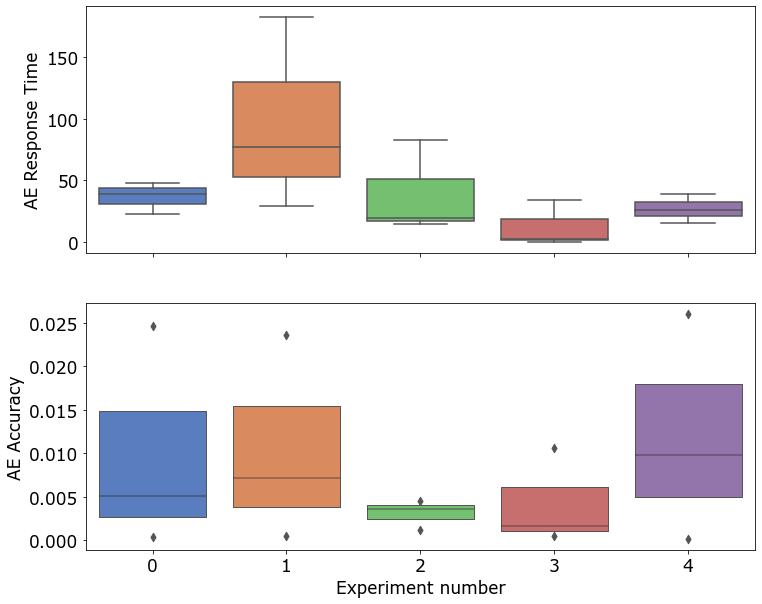

In [89]:
# Print the mean squared error between time and predicted
print('Errors in time')
print(mean_squared_error(df_c['time'], df_c['predicted_time']))
print(mean_squared_error(df_other['time'], df_other['predicted_time']))

# Print the mean squared error in accuracy
print('\n\nerrors in accuracy')
print(mean_squared_error(df_c['final_accuracy'], df_c['predicted_accuracy']))
print(mean_squared_error(df_other['final_accuracy'], df_other['predicted_accuracy']))

plt.rc('font', size=17)

# sns.set_palette()
f, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True)

sns.boxplot(x=df_c.index % 5, y=np.sqrt(df_c.error_time), data=df_c, ax=ax1, palette='muted')
sns.boxenplot(x=df_c.index % 5, y=np.sqrt(df_c.error_acc), data=df_c, ax=ax2, palette='muted')




ax2.set_xlabel('Experiment number')
ax1.set_ylabel('AE Response Time')
ax2.set_ylabel('AE Accuracy')


plt.savefig('./figures/courier_performance.pdf')




# get a significance test
from scipy.stats import shapiro, mannwhitneyu

_,p_t = mannwhitneyu(df_c['error_time'], df_r['error_time'])
_,p_acc = mannwhitneyu(df_c['error_acc'], df_r['error_acc'])
print(p_t, p_acc)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
sns.barplot(x=df_c.index % 5, y=df_c.slo, data=df_c, ax=ax1)
sns.barplot(x=df_other.index % 5, y=df_r.slo, data=df_r, ax=ax2)
ax1.set_xlabel('Experiment Number')
ax2.set_xlabel('Experiment Number')
ax1.set_ylabel('Response Time - Latency SLO (s)')

plt.savefig('./figures/courier-vs-random_slo.pdf')


f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.barplot(x=df_c.index % 5, y=df_c.final_accuracy, data=df_c, ax=ax1)
sns.barplot(x=df_r.index % 5, y=df_r.final_accuracy, data=df_r, ax=ax2)
ax1.set_ylim([0.88, 0.96])

ax1.set_xlabel('Experiment Number')
ax2.set_xlabel('Experiment Number')
ax1.set_ylabel('Final Accuracy')

plt.savefig('./figures/courier-vs-random_accuracy.pdf')

In [ ]:
df_c

In [ ]:
df_other